In [ ]:
# 1_check_file_size.py
import os
SRC = "/content/drive/MyDrive/oasis_project/oasis2_graph_dataset.pt"
if os.path.exists(SRC):
    sz = os.path.getsize(SRC)
    print("SRC exists:", SRC)
    print("size (bytes):", sz)
    print("size (MB):", round(sz/1024/1024, 3))
else:
    print("SRC not found:", SRC)


SRC exists: /content/drive/MyDrive/oasis_project/oasis2_graph_dataset.pt
size (bytes): 5242880
size (MB): 5.0


In [ ]:
# try_alternate_outputs_and_copy.py
import os, torch, shutil
BASE = "/content/drive/MyDrive/oasis_project"
outputs_dir = os.path.join(BASE, "outputs")
out_path = os.path.join(BASE, "data", "graphs", "oasis2_graphs_unlabeled.pt")

print("Searching PT files in outputs:", outputs_dir)
if not os.path.exists(outputs_dir):
    raise FileNotFoundError(outputs_dir)

candidates = [fn for fn in sorted(os.listdir(outputs_dir)) if fn.lower().endswith(".pt")]
print("Candidates:", candidates)

good = []
for fn in candidates:
    path = os.path.join(outputs_dir, fn)
    try:
        obj = torch.load(path, map_location="cpu")
        # attempt to get a sensible length or shape
        try:
            ln = len(obj) if isinstance(obj, (list, tuple, dict)) else ("single_obj")
        except Exception:
            ln = "unknown_len"
        print("LOAD OK:", fn, "-> type:", type(obj), "len:", ln)
        good.append((fn, path, ln))
    except Exception as e:
        print("LOAD FAIL:", fn, type(e).__name__, e)

if good:
    src_ok = good[0][1]
    print("\nCopying first good file:", good[0][0], "->", out_path)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    shutil.copyfile(src_ok, out_path)
    # verify load
    try:
        loaded = torch.load(out_path, map_location="cpu")
        ln2 = len(loaded) if isinstance(loaded, (list, tuple, dict)) else "single_obj"
        print("Verified copied file loaded OK; len:", ln2)
    except Exception as e:
        print("Warning: copied file failed to load:", e)
else:
    print("\nNo good .pt found in outputs. Nothing copied.")


Searching PT files in outputs: /content/drive/MyDrive/oasis_project/outputs
Candidates: ['model_best.pt', 'model_best_realonly.pt', 'model_best_weighted.pt', 'model_epoch1.pt', 'model_epoch10.pt', 'model_epoch2.pt', 'model_epoch3.pt', 'model_epoch4.pt', 'model_epoch5.pt', 'model_epoch6.pt', 'model_epoch7.pt', 'model_epoch8.pt', 'model_epoch9.pt', 'model_epoch_realonly_1.pt', 'model_epoch_realonly_10.pt', 'model_epoch_realonly_2.pt', 'model_epoch_realonly_3.pt', 'model_epoch_realonly_4.pt', 'model_epoch_realonly_5.pt', 'model_epoch_realonly_6.pt', 'model_epoch_realonly_7.pt', 'model_epoch_realonly_8.pt', 'model_epoch_realonly_9.pt', 'model_final_weighted.pt', 'oasis2_graph_dataset_drivecopy_new.pt', 'oasis2_graph_dataset_final.pt', 'oasis2_graph_dataset_labeled_realonly.pt']
LOAD OK: model_best.pt -> type: <class 'collections.OrderedDict'> len: 8
LOAD OK: model_best_realonly.pt -> type: <class 'collections.OrderedDict'> len: 8
LOAD OK: model_best_weighted.pt -> type: <class 'collections

In [ ]:
# 1_cleanup_wrong_copy.py
import os
OUT_FILE = "/content/drive/MyDrive/oasis_project/data/graphs/oasis2_graphs_unlabeled.pt"
if os.path.exists(OUT_FILE):
    print("Removing", OUT_FILE, " (it currently contains a model checkpoint).")
    os.remove(OUT_FILE)
else:
    print("No existing OUT_FILE to remove.")
print("Done.")


Removing /content/drive/MyDrive/oasis_project/data/graphs/oasis2_graphs_unlabeled.pt  (it currently contains a model checkpoint).
Done.


In [ ]:
# 2_try_load_datasets_with_safe_globals.py
import os, torch, traceback, shutil
BASE = "/content/drive/MyDrive/oasis_project"
outputs_dir = os.path.join(BASE, "outputs")
candidates = [
    "oasis2_graph_dataset_drivecopy_new.pt",
    "oasis2_graph_dataset_final.pt",
    "oasis2_graph_dataset_labeled_realonly.pt"
]
candidates = [os.path.join(outputs_dir, c) for c in candidates if os.path.exists(os.path.join(outputs_dir, c))]
print("Attempting safe-load for candidates:", candidates)
success = []
for path in candidates:
    print("\nTrying:", path)
    try:
        # we use add_safe_globals context manager to allowlist torch_geometric classes
        from torch.serialization import add_safe_globals
        # import the classes we expect to appear in the pickle
        try:
            import torch_geometric
            from torch_geometric.data.data import Data, DataEdgeAttr
            safe_list = [Data, DataEdgeAttr]
        except Exception:
            # fallback to string names if import fails (less ideal)
            safe_list = []
        if len(safe_list)>0:
            with add_safe_globals(safe_list):
                obj = torch.load(path, map_location='cpu')
        else:
            # still try without add_safe_globals (may raise)
            obj = torch.load(path, map_location='cpu')
        print("Loaded OK:", type(obj), "len:", (len(obj) if isinstance(obj, (list,tuple,dict)) else 'single_obj'))
        success.append((path, obj))
    except Exception as e:
        print("Failed to load:", type(e).__name__, str(e))
        traceback.print_exc()

# if any successful loads, save the first one into OUT
if success:
    out_file = os.path.join(BASE, "data", "graphs", "oasis2_graphs_unlabeled.pt")
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    path, obj = success[0]
    print("\nSaving recovered dataset from:", path, "->", out_file)
    torch.save(obj, out_file)
    print("Saved. Verification load...")
    v = torch.load(out_file, map_location='cpu')
    print("Verified loaded type:", type(v), "len:", (len(v) if isinstance(v, (list,tuple,dict)) else 'single_obj'))
else:
    print("\nNo candidate could be safe-loaded. Nothing saved.")


Attempting safe-load for candidates: ['/content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_drivecopy_new.pt', '/content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_final.pt', '/content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_labeled_realonly.pt']

Trying: /content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_drivecopy_new.pt
Failed to load: TypeError 'NoneType' object does not support the context manager protocol

Trying: /content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_final.pt
Failed to load: TypeError 'NoneType' object does not support the context manager protocol

Trying: /content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_labeled_realonly.pt
Failed to load: TypeError 'NoneType' object does not support the context manager protocol

No candidate could be safe-loaded. Nothing saved.


Traceback (most recent call last):
  File "/tmp/ipython-input-2223217300.py", line 27, in <cell line: 0>
    with add_safe_globals(safe_list):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'NoneType' object does not support the context manager protocol
Traceback (most recent call last):
  File "/tmp/ipython-input-2223217300.py", line 27, in <cell line: 0>
    with add_safe_globals(safe_list):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'NoneType' object does not support the context manager protocol
Traceback (most recent call last):
  File "/tmp/ipython-input-2223217300.py", line 27, in <cell line: 0>
    with add_safe_globals(safe_list):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'NoneType' object does not support the context manager protocol


In [ ]:
# 3_install_tg.sh (run in a notebook cell with ! at start)
# This installs PyTorch Geometric for the current CUDA / CPU setup in Colab.
# If you know your CUDA version, adapt the wheels from https://pytorch-geometric.readthedocs.io
# The command below attempts a generic install via pip (may be slower).
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --quiet


In [ ]:
# try_load_with_weights_only_false.py
import os, torch, shutil, traceback
BASE = "/content/drive/MyDrive/oasis_project"
outputs_dir = os.path.join(BASE, "outputs")
candidates = [
    "oasis2_graph_dataset_drivecopy_new.pt",
    "oasis2_graph_dataset_final.pt",
    "oasis2_graph_dataset_labeled_realonly.pt"
]
candidates = [os.path.join(outputs_dir, c) for c in candidates if os.path.exists(os.path.join(outputs_dir, c))]
out_file = os.path.join(BASE, "data", "graphs", "oasis2_graphs_unlabeled.pt")
print("Candidates to try:", candidates)

success = []
for path in candidates:
    print("\nTrying to load:", path)
    try:
        obj = torch.load(path, map_location="cpu", weights_only=False)
        ln = (len(obj) if isinstance(obj, (list,tuple,dict)) else "single_obj")
        print("Loaded OK:", path, "type:", type(obj), "len:", ln)
        success.append((path, obj))
        break
    except Exception as e:
        print("Failed to load:", type(e).__name__, e)
        traceback.print_exc()

if success:
    src_path, obj = success[0]
    print("\nSaving recovered dataset to:", out_file)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    torch.save(obj, out_file)
    print("Saved. Verifying load of saved file...")
    try:
        v = torch.load(out_file, map_location="cpu")
        print("Verification OK. Loaded type:", type(v), "len:", (len(v) if isinstance(v, (list,tuple,dict)) else "single_obj"))
    except Exception as e:
        print("Verification load failed:", type(e).__name__, e)
else:
    print("\nNone of the candidate files could be loaded with weights_only=False.")


Candidates to try: ['/content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_drivecopy_new.pt', '/content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_final.pt', '/content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_labeled_realonly.pt']

Trying to load: /content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_drivecopy_new.pt
Loaded OK: /content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_drivecopy_new.pt type: <class 'list'> len: 209

Saving recovered dataset to: /content/drive/MyDrive/oasis_project/data/graphs/oasis2_graphs_unlabeled.pt
Saved. Verifying load of saved file...
Verification load failed: UnpicklingError Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only`

In [ ]:
# 1_load_and_confirm.py
import os, torch, numpy as np, pandas as pd
BASE = "/content/drive/MyDrive/oasis_project"
SRC = os.path.join(BASE, "outputs", "oasis2_graph_dataset_drivecopy_new.pt")

print("Loading dataset with weights_only=False (trusted local file):", SRC)
graphs = torch.load(SRC, map_location="cpu", weights_only=False)
print("Loaded type:", type(graphs), "len:", (len(graphs) if isinstance(graphs, (list,tuple)) else 'single_obj'))

# ensure list
if not isinstance(graphs, list):
    try:
        graphs = list(graphs)
    except Exception:
        graphs = [graphs]

print("Number of graphs:", len(graphs))
# quick summary for first 20
rows = []
for i,g in enumerate(graphs[:20]):
    sid = getattr(g, "subject_id", None) or getattr(g, "id", None) or f"subj_{i}"
    x = getattr(g, "x", None)
    ei = getattr(g, "edge_index", None)
    pos = getattr(g, "pos", None)
    rows.append({
        "idx": i,
        "subject_id": sid,
        "n_nodes": int(x.shape[0]) if x is not None else None,
        "feat_dim": int(x.shape[1]) if (x is not None and x.ndim>1) else None,
        "n_edges": int(ei.shape[1]) if ei is not None else None,
        "pos_shape": tuple(pos.shape) if pos is not None else None
    })
df = pd.DataFrame(rows)
print(df.to_string(index=False))

# global stats
node_counts = [int(getattr(g, "x", None).shape[0]) for g in graphs if getattr(g, "x", None) is not None]
edge_counts = [int(getattr(g, "edge_index", None).shape[1]) for g in graphs if getattr(g, "edge_index", None) is not None]
if node_counts:
    print("\nNodes per graph -> min/median/mean/max:", np.min(node_counts), np.median(node_counts), np.mean(node_counts), np.max(node_counts))
if edge_counts:
    print("Edges per graph -> min/median/mean/max:", np.min(edge_counts), np.median(edge_counts), np.mean(edge_counts), np.max(edge_counts))


Loading dataset with weights_only=False (trusted local file): /content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_drivecopy_new.pt
Loaded type: <class 'list'> len: 209
Number of graphs: 209
 idx subject_id  n_nodes  feat_dim  n_edges pos_shape
   0     subj_0     1575        50    21188      None
   1     subj_1     1575        50    21272      None
   2     subj_2     1575        50    21792      None
   3     subj_3     1575        50    22082      None
   4     subj_4     1575        50    21722      None
   5     subj_5     1575        50    22176      None
   6     subj_6     1575        50    21960      None
   7     subj_7     1575        50    21990      None
   8     subj_8     1575        50    22150      None
   9     subj_9     1575        50    21150      None
  10    subj_10     1575        50    21870      None
  11    subj_11     1575        50    22062      None
  12    subj_12     1575        50    21760      None
  13    subj_13     1575        50    22

In [ ]:
# 2_write_subjects_csv.py
import os, pandas as pd
OUT = os.path.join(BASE, "data", "graphs")
os.makedirs(OUT, exist_ok=True)

records = []
for idx,g in enumerate(graphs):
    sid = getattr(g, "subject_id", None) or getattr(g, "id", None) or f"subj_{idx}"
    records.append({"index": idx, "subject_id": str(sid)})
df = pd.DataFrame(records)
csv_path = os.path.join(OUT, "graph_subjects.csv")
df.to_csv(csv_path, index=False)
print("Saved subject mapping to:", csv_path)
print(df.head())


Saved subject mapping to: /content/drive/MyDrive/oasis_project/data/graphs/graph_subjects.csv
   index subject_id
0      0     subj_0
1      1     subj_1
2      2     subj_2
3      3     subj_3
4      4     subj_4


In [ ]:
# 3_make_and_save_splits.py
import os, json, random
OUT = os.path.join(BASE, "data", "graphs")
N = len(graphs)
idxs = list(range(N))
random.seed(42)
random.shuffle(idxs)
n_train = int(0.8 * N)
n_val = int(0.1 * N)
train_idx = idxs[:n_train]
val_idx   = idxs[n_train:n_train+n_val]
test_idx  = idxs[n_train+n_val:]
splits = {"train": train_idx, "val": val_idx, "test": test_idx}
with open(os.path.join(OUT, "graph_splits.json"), "w") as f:
    json.dump(splits, f)
print("Saved splits ->", os.path.join(OUT, "graph_splits.json"))
print("Counts: train/val/test =", len(train_idx), len(val_idx), len(test_idx))


Saved splits -> /content/drive/MyDrive/oasis_project/data/graphs/graph_splits.json
Counts: train/val/test = 167 20 22


In [ ]:
# 4_create_dataloaders_show_batch.py
import json, os, torch
from torch_geometric.loader import DataLoader

OUT = os.path.join(BASE, "data", "graphs")
with open(os.path.join(OUT, "graph_splits.json"), "r") as f:
    splits = json.load(f)

train_ds = [graphs[i] for i in splits["train"]]
val_ds   = [graphs[i] for i in splits["val"]]
test_ds  = [graphs[i] for i in splits["test"]]

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)
test_loader = DataLoader(test_ds, batch_size=8)

print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))
# show one batch
for batch in train_loader:
    print("batch.x shape:", batch.x.shape, "batch.batch shape:", batch.batch.shape, "batch.edge_index shape:", batch.edge_index.shape)
    break


Train/Val/Test sizes: 167 20 22
batch.x shape: torch.Size([12600, 50]) batch.batch shape: torch.Size([12600]) batch.edge_index shape: torch.Size([2, 175384])


In [ ]:
# 5_optional_save_graphs.py
import os, torch
OUT = os.path.join(BASE, "data", "graphs")
out_file = os.path.join(OUT, "oasis2_graphs_unlabeled.pt")
print("Saving graphs to:", out_file, " (may not be loadable by torch.load default in other envs)")
torch.save(graphs, out_file)
print("Saved.")


Saving graphs to: /content/drive/MyDrive/oasis_project/data/graphs/oasis2_graphs_unlabeled.pt  (may not be loadable by torch.load default in other envs)
Saved.


In [ ]:
# save_graphs_as_npz.py
import os, numpy as np, pandas as pd, torch
BASE = "/content/drive/MyDrive/oasis_project"
OUT = os.path.join(BASE, "data", "graphs")
npz_dir = os.path.join(OUT, "npz_graphs")
os.makedirs(npz_dir, exist_ok=True)

# LOAD original dataset into graphs (we already have it in memory as 'graphs' if you ran previous)
# If not in memory, re-load trusted source:
src = os.path.join(BASE, "outputs", "oasis2_graph_dataset_drivecopy_new.pt")
graphs = torch.load(src, map_location='cpu', weights_only=False)
if not isinstance(graphs, list):
    graphs = list(graphs)

rows = []
for idx, g in enumerate(graphs):
    sid = getattr(g, "subject_id", None) or getattr(g, "id", None) or f"subj_{idx}"
    x = g.x.cpu().numpy() if hasattr(g, "x") and g.x is not None else None
    pos = g.pos.cpu().numpy() if hasattr(g, "pos") and g.pos is not None else None
    ei = g.edge_index.cpu().numpy() if hasattr(g, "edge_index") and g.edge_index is not None else None
    fname = f"graph_{idx:04d}_{sid}.npz"
    np.savez_compressed(os.path.join(npz_dir, fname),
                        x=x, pos=pos, edge_index=ei)
    rows.append({"index": idx, "subject_id": sid, "npz_file": fname,
                 "n_nodes": int(x.shape[0]) if x is not None else 0,
                 "feat_dim": int(x.shape[1]) if (x is not None and x.ndim>1) else None})
print("Saved", len(rows), "graphs to", npz_dir)
pd.DataFrame(rows).to_csv(os.path.join(OUT, "graph_index.csv"), index=False)
print("Saved index CSV ->", os.path.join(OUT, "graph_index.csv"))

Saved 209 graphs to /content/drive/MyDrive/oasis_project/data/graphs/npz_graphs
Saved index CSV -> /content/drive/MyDrive/oasis_project/data/graphs/graph_index.csv


In [ ]:
# load_one_npz.py
import os, numpy as np
BASE = "/content/drive/MyDrive/oasis_project"
npz_dir = os.path.join(BASE, "data", "graphs", "npz_graphs")
p = sorted([os.path.join(npz_dir,f) for f in os.listdir(npz_dir) if f.endswith(".npz")])[0]
d = np.load(p, allow_pickle=True)
print("Loaded:", p)
print("x:", d['x'].shape, "pos:", d['pos'].shape, "edge_index:", d['edge_index'].shape)

Loaded: /content/drive/MyDrive/oasis_project/data/graphs/npz_graphs/graph_0000_subj_0.npz
x: (1575, 50) pos: () edge_index: (2, 21188)


In [ ]:
# npz_to_pyg_dataloaders.py
import os, numpy as np, json, torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

BASE = "/content/drive/MyDrive/oasis_project"
npz_dir = os.path.join(BASE, "data", "graphs", "npz_graphs")
index_csv = os.path.join(BASE, "data", "graphs", "graph_index.csv")
splits_json = os.path.join(BASE, "data", "graphs", "graph_splits.json")

# load index (optional) or scan dir
files = sorted([os.path.join(npz_dir,f) for f in os.listdir(npz_dir) if f.endswith(".npz")])
graphs = []
for f in files:
    d = np.load(f, allow_pickle=True)
    x = torch.tensor(d['x'], dtype=torch.float)
    edge_index = torch.tensor(d['edge_index'], dtype=torch.long)
    pos = d['pos']
    # create Data
    g = Data(x=x, edge_index=edge_index)
    if pos.shape != (): # Check if pos is a valid numpy array before adding
        g.pos = torch.tensor(pos, dtype=torch.float)
    graphs.append(g)


# splits
with open(splits_json,'r') as fh:
    splits = json.load(fh)
train_ds = [graphs[i] for i in splits['train']]
val_ds   = [graphs[i] for i in splits['val']]
test_ds  = [graphs[i] for i in splits['test']]

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=8)
test_loader  = DataLoader(test_ds, batch_size=8)

print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))
for batch in train_loader:
    print("batch.x", batch.x.shape, "batch.batch", batch.batch.shape, "edge_index", batch.edge_index.shape)
    break

Train/Val/Test sizes: 167 20 22
batch.x torch.Size([12600, 50]) batch.batch torch.Size([12600]) edge_index torch.Size([2, 174792])


In [ ]:
# train_demo.py  (assumes dataloaders from above)
import torch, torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class SimpleGNN(torch.nn.Module):
    def __init__(self, in_dim, hidden=64, num_classes=2):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = torch.nn.Linear(hidden, num_classes)
    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_dim = graphs[0].x.shape[1]
model = SimpleGNN(in_dim, hidden=64, num_classes=2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for batch in train_loader:
    batch = batch.to(device)
    # placeholder labels (replace with real labels)
    y = torch.zeros(batch.num_graphs, dtype=torch.long, device=device)
    out = model(batch.x, batch.edge_index, batch.batch)
    loss = F.cross_entropy(out, y)
    loss.backward(); opt.step()
    print("loss", loss.item())
    break


loss 0.7111612558364868


Installing umap-learn ...
Installing scikit-learn ...
Found NPZ graphs: 209


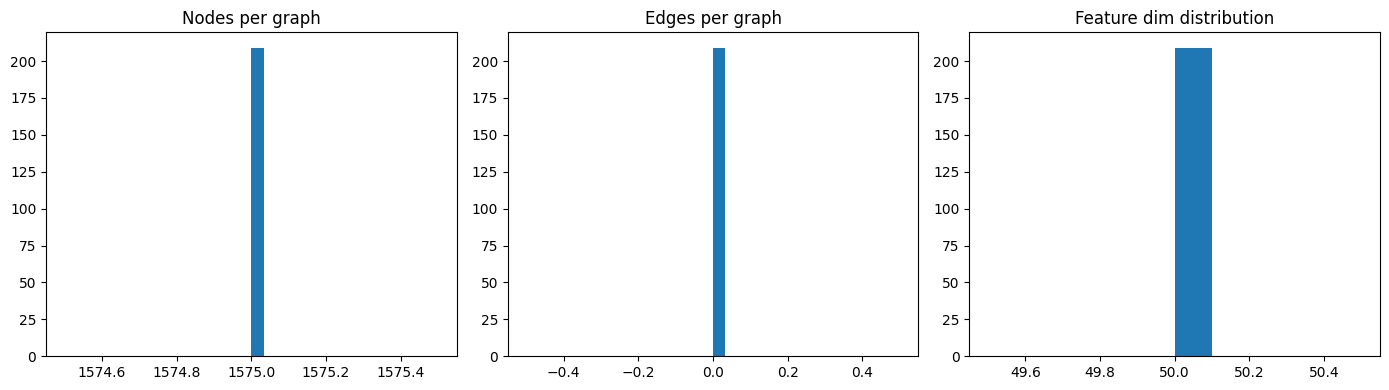

No graph found with valid 3D position data for visualization.
Sampling node features for UMAP (this may take a little while)...
Sampled nodes shape: (4807, 50)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Computing graph-level pooled features...
Graph-level feature matrix shape: (209, 150)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Adjacency heatmap for sample graph:
No graph found with valid edge data for adjacency heatmap visualization.
NetworkX 2D layout for sample graph:
No graph found with valid edge and node data for NetworkX layout visualization.
Visualization cell finished. Tweak SAMPLE_NODES, PLOTLY_RENDERER or MAX_EDGES_DRAW if you need to scale visuals.


In [ ]:
# ALL-IN-ONE Visualization snippet for the recovered graphs (one cell)
# Paste & run in Colab / Jupyter. Uses NPZ exports in data/graphs/npz_graphs.
# Note: this loader uses allow_pickle=True (safe because files are trusted & come from your Drive).
# If packages are missing, the cell will attempt to install them automatically.

import os, glob, numpy as np, math, random, json, sys
import matplotlib.pyplot as plt
from matplotlib import cm
import traceback

# Try to import optional libs and install if missing
def pip_install(pkg):
    try:
        import importlib
        importlib.import_module(pkg)
    except Exception:
        print(f"Installing {pkg} ...")
        !pip install -q {pkg}

# required non-standard libs
for pkg in ("plotly", "umap_learn", "networkx", "scikit-learn"):
    # map package name to pip install name for umap and scikit-learn
    pip_name = pkg if pkg != "umap_learn" else "umap-learn"
    pip_install(pip_name)

# now imports that rely on installed packages
import plotly.express as px
import plotly.graph_objects as go
import umap
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# CONFIG (edit if needed)
BASE = "/content/drive/MyDrive/oasis_project"
OUT = os.path.join(BASE, "data", "graphs")
npz_dir = os.path.join(OUT, "npz_graphs")
PLOTLY_RENDERER = "colab"  # use "notebook" if using classic notebook; "colab" for Colab
SAMPLE_NODES = 5000        # how many nodes total to sample for node-level UMAP
NODE_UMAP_MIN_PER_GRAPH = 10
GRAPH_UMAP_COMP = 2
RANDOM_SEED = 42
MAX_EDGES_DRAW = 10000     # limit edge lines drawn in 3D

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# set plotly renderer
import plotly.io as pio
try:
    pio.renderers.default = PLOTLY_RENDERER
except Exception:
    pass

# --- Helper: robust NPZ loader (allow_pickle + normalize edge_index) ---
def safe_load_npz(path):
    """
    Load .npz with allow_pickle and normalize edge_index into shape (2, E) int64 array.
    Returns dict with keys: x (ndarray), pos (ndarray), edge_index (2,E int64 ndarray)
    """
    try:
        d = np.load(path, allow_pickle=True)
    except Exception as e:
        raise RuntimeError(f"Failed to np.load {path}: {e}")

    x = None
    for key in ['x', 'X', 'feat', 'features']:
        if key in d:
            x = d[key]
            break

    pos = None
    for key in ['pos', 'positions', 'coords', 'pos_xyz']:
        if key in d:
            pos = d[key]
            break

    ei_raw = None
    for key in ['edge_index', 'edges', 'edge_idx']:
        if key in d:
            ei_raw = d[key]
            break

    # ensure numpy arrays (or None if not found/invalid)
    x = np.asarray(x) if x is not None else None
    pos = np.asarray(pos) if pos is not None else None
    ei_raw = np.asarray(ei_raw) if ei_raw is not None else None

    # normalize edge_index to shape (2, E)
    ei_arr = np.empty((2,0), dtype=np.int64) # Default empty
    if ei_raw is not None:
        try:
            # if object dtype, try to transform
            if getattr(ei_raw, 'dtype', None) == object:
                # attempts: list-of-two arrays, list-of-pairs, array-of-pairs
                try:
                    li = ei_raw.tolist()
                    arr = np.asarray(li)
                    if arr.ndim == 2 and arr.shape[0] == 2:
                        ei_arr = arr.astype(np.int64)
                    elif arr.ndim == 2 and arr.shape[1] == 2:
                        ei_arr = arr.T.astype(np.int64)
                    else:
                        # flatten sequence of pairs
                        flat = np.concatenate([np.asarray(v).reshape(-1) for v in li])
                        if flat.size % 2 == 0:
                            ei_arr = flat.reshape(2, -1).astype(np.int64)
                        else:
                            ei_arr = np.empty((2,0), dtype=np.int64)
                except Exception:
                    ei_arr = np.empty((2,0), dtype=np.int64)
            else:
                # numeric array
                if ei_raw.ndim == 1:
                    # reshape if even
                    if ei_raw.size % 2 == 0:
                        try:
                            ei_arr = ei_raw.reshape(2, -1)
                        except:
                            ei_arr = ei_raw.reshape(-1,2).T
                    else:
                        ei_arr = np.empty((2,0), dtype=np.int64)
                elif ei_raw.ndim == 2:
                    if ei_raw.shape[0] != 2 and ei_raw.shape[1] == 2:
                        ei_arr = ei_raw.T
                    ei_arr = ei_arr.astype(np.int64)
                else:
                    ei_arr = np.empty((2,0), dtype=np.int64)
        except Exception:
            ei_arr = np.empty((2,0), dtype=np.int64)

    return {"x": x, "pos": pos, "edge_index": ei_arr}

# --- Discover NPZ files ---
npz_files = sorted(glob.glob(os.path.join(npz_dir, "*.npz")))
if len(npz_files) == 0:
    raise RuntimeError(f"No npz graphs found in {npz_dir}. Run export step first.")

print("Found NPZ graphs:", len(npz_files))

# --- 1) Dataset summary histograms ---
node_counts = []
edge_counts = []
feat_dims = []
for f in npz_files:
    try:
        d = safe_load_npz(f)
        if d['x'] is not None:
            node_counts.append(int(d['x'].shape[0]))
            feat_dims.append(int(d['x'].shape[1]) if d['x'].ndim>1 else 1)
        if d['edge_index'] is not None:
            edge_counts.append(int(d['edge_index'].shape[1]))
    except Exception as e:
        print("Warning loading", f, ":", e)
plt.figure(figsize=(14,4))
plt.subplot(1,3,1); plt.hist(node_counts, bins=30); plt.title("Nodes per graph")
plt.subplot(1,3,2); plt.hist(edge_counts, bins=30); plt.title("Edges per graph")
plt.subplot(1,3,3); plt.hist(feat_dims, bins=10); plt.title("Feature dim distribution")
plt.tight_layout()
plt.show()

# --- 2) 3D interactive view for a chosen graph (default: first) ---
def plot_graph_3d(npz_path, node_size=2, max_edges=MAX_EDGES_DRAW, edge_alpha=0.15, title=None):
    d = safe_load_npz(npz_path)
    pos = d['pos']; ei = d['edge_index']

    if pos is None or pos.shape == () or pos.ndim != 2 or pos.shape[1] != 3:
        print(f"Skipping 3D plot for {os.path.basename(npz_path)}: 'pos' data is missing, empty, or not 3D.")
        return None

    N = pos.shape[0]
    # compute degree
    deg = np.zeros(N, dtype=int)
    if ei is not None and ei.size>0 and ei.ndim == 2 and ei.shape[0] == 2:
        r, c = ei
        # clip and valid mask
        valid = (r>=0)&(r<N)&(c>=0)&(c<N)
        r = r[valid]; c = c[valid]
        deg = np.bincount(np.concatenate([r,c]), minlength=N)
    # nodes
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=pos[:,0], y=pos[:,1], z=pos[:,2],
        mode='markers',
        marker=dict(size=node_size, color=deg, colorscale='Viridis', opacity=0.9, colorbar=dict(title='degree')),
        hoverinfo='skip'
    ))
    # edges (line segments)
    if show_edges and ei is not None and ei.size>0 and ei.ndim == 2 and ei.shape[0] == 2:
        r, c = ei
        valid = (r>=0)&(r<N)&(c>=0)&(c<N)
        r = r[valid]; c = c[valid]
        E = len(r)
        idxs = np.arange(E)
        if E > max_edges:
            idxs = np.random.choice(E, max_edges, replace=False)
        xs, ys, zs = [], [], []
        for i in idxs:
            a = r[i]; b = c[i]
            xs += [float(pos[a,0]), float(pos[b,0]), None]
            ys += [float(pos[a,1]), float(pos[b,1]), None]
            zs += [float(pos[a,2]), float(pos[b,2]), None]
        fig.add_trace(go.Scatter3d(x=xs, y=ys, z=zs, mode='lines',
                                   line=dict(width=1, color=f'rgba(150,150,150,{edge_alpha})'),
                                   hoverinfo='none', showlegend=False))
    fig.update_layout(title=title or os.path.basename(npz_path), scene=dict(aspectmode='data'))
    return fig

# render 3D for the first graph that has valid 3D pos data
sample_path_3d = None
for f in npz_files:
    d = safe_load_npz(f)
    if d['pos'] is not None and d['pos'].shape != () and d['pos'].ndim == 2 and d['pos'].shape[1] == 3:
        sample_path_3d = f
        break

if sample_path_3d:
    print("Rendering 3D for:", sample_path_3d)
    fig = plot_graph_3d(sample_path_3d, node_size=2)
    if fig is not None:
        fig.show(renderer=PLOTLY_RENDERER)
else:
    print("No graph found with valid 3D position data for visualization.")


# --- 3) Node-level UMAP across sampled nodes (interactive) ---
def sample_node_features(npz_files, max_nodes=SAMPLE_NODES, min_per_graph=NODE_UMAP_MIN_PER_GRAPH):
    X_list = []; meta = []
    per_graph = max(min_per_graph, max_nodes // max(1, len(npz_files)))
    total = 0
    for gi, p in enumerate(npz_files):
        try:
            d = safe_load_npz(p)
            x = d['x']
            if x is None or x.shape[0] == 0: continue
            n = x.shape[0]
            k = min(n, per_graph)
            idxs = np.random.choice(n, k, replace=False) if n>=k else np.random.choice(n, k, replace=True)
            X_list.append(x[idxs])
            meta += [(gi, int(i)) for i in idxs]
            total += k
            if total >= max_nodes:
                break
        except Exception:
            continue
    if len(X_list) == 0:
        # Handle case where no nodes were sampled
        print("Warning: No node features sampled for UMAP.")
        return np.array([]), []
    X = np.vstack(X_list).astype(np.float32)
    return X, meta

print("Sampling node features for UMAP (this may take a little while)...")
X_nodes, metas = sample_node_features(npz_files, max_nodes=SAMPLE_NODES)
print("Sampled nodes shape:", X_nodes.shape)

if X_nodes.shape[0] > 0 and X_nodes.shape[1] > 1: # Need at least one node with features for UMAP
    # standardize then UMAP
    try:
        Xs = StandardScaler().fit_transform(X_nodes)
    except Exception:
        Xs = X_nodes
    reducer = umap.UMAP(n_components=2, random_state=RANDOM_SEED)
    Z = reducer.fit_transform(Xs)
    # color by kmeans on PCA
    pca_components = min(16, Xs.shape[1])
    if pca_components > 0:
        pca = PCA(n_components=pca_components).fit_transform(Xs)
        kmeans_clusters = min(6, pca.shape[0])
        if kmeans_clusters > 1:
            kmeans = KMeans(n_clusters=kmeans_clusters, random_state=RANDOM_SEED, n_init=10).fit(pca)
            labels = kmeans.labels_.astype(str)
            fig = px.scatter(x=Z[:,0], y=Z[:,1], color=labels, title="UMAP of sampled node features (clustered)", width=900, height=700)
            fig.update_traces(marker=dict(size=4))
            fig.show(renderer=PLOTLY_RENDERER)
        else:
            print("Not enough data for KMeans clustering for node UMAP visualization.")
    else:
        print("Node features have insufficient dimensions for PCA and KMeans for UMAP visualization.")
else:
    print("Not enough sampled nodes with features for UMAP visualization.")


# --- 4) Graph-level pooled embeddings (mean,std,max) -> UMAP + clustering ---
def graph_level_matrix(npz_files):
    mats = []; names = []
    for p in npz_files:
        try:
            d = safe_load_npz(p)
            x = d['x']
            if x is None or x.size==0:
                # Handle graphs with no node features - skip or use zero vector
                print(f"Warning: Skipping graph {os.path.basename(p)} for graph-level stats due to missing or empty node features.")
                continue
            if x.ndim == 1: # Handle 1D features
                 x = x[:, np.newaxis]
            # compute mean, std, max and concatenate
            # Ensure enough samples for std deviation if needed, or handle appropriately
            if x.shape[0] > 1:
                 mean = np.mean(x, axis=0)
                 std = np.std(x, axis=0)
                 mx = np.max(x, axis=0)
                 feat = np.concatenate([mean, std, mx])
            else: # Handle single node graphs differently
                 mean = np.mean(x, axis=0)
                 std = np.zeros_like(mean) # Use zeros for std if only one node
                 mx = np.max(x, axis=0)
                 feat = np.concatenate([mean, std, mx])

            mats.append(feat)
            names.append(os.path.basename(p))
        except Exception as e:
            print(f"Error processing graph {os.path.basename(p)} for graph-level stats: {e}")
            continue # Skip graph if processing fails
    if not mats:
        return np.array([]), [] # Return empty arrays if no graphs were processed
    M = np.vstack(mats).astype(np.float32)
    return M, names

print("Computing graph-level pooled features...")
Gmat, Gnames = graph_level_matrix(npz_files)
print("Graph-level feature matrix shape:", Gmat.shape)

if Gmat.shape[0] > 1 and Gmat.shape[1] > 1: # Need at least 2 samples and 2 features for UMAP
    # reduce via UMAP
    reducer_g = umap.UMAP(n_components=2, random_state=RANDOM_SEED)
    Gred = reducer_g.fit_transform(Gmat)
    k = min(6, max(2, int(len(Gmat)**0.5)))
    if k > 1: # Need at least 2 clusters for KMeans
        km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10).fit(Gred)
        fig = px.scatter(x=Gred[:,0], y=Gred[:,1], color=km.labels_.astype(str), hover_name=Gnames,
                         title="Graph-level UMAP (pooled features) + KMeans", width=900, height=700)
        fig.show(renderer=PLOTLY_RENDERER)
    else:
         print("Not enough graphs for KMeans clustering for graph-level UMAP visualization.")
else:
    print("Not enough graphs or features for graph-level UMAP visualization.")

# --- 5) Adjacency heatmap for a selected graph (matplotlib) ---
def adjacency_heatmap(npz_path, max_size=500):
    d = safe_load_npz(npz_path)
    ei = d['edge_index']

    if ei is None or ei.size == 0 or ei.ndim != 2 or ei.shape[0] != 2:
        print(f"Skipping adjacency heatmap for {os.path.basename(npz_path)}: 'edge_index' data is missing, empty, or not in expected shape (2, E).")
        return

    r, c = ei
    N = int(max(r.max(), c.max()) + 1) if r.size > 0 and c.size > 0 else 0

    if N == 0:
        print(f"Skipping adjacency heatmap for {os.path.basename(npz_path)}: No nodes found based on edge index.")
        return

    # limit to first max_size nodes for visualization
    idx_keep = np.arange(min(N, max_size))
    A = np.zeros((len(idx_keep), len(idx_keep)), dtype=int)
    for rr, cc in zip(r, c):
        if rr < len(idx_keep) and cc < len(idx_keep):
            A[int(rr), int(cc)] = 1
    plt.figure(figsize=(6,6))
    plt.imshow(A, cmap='viridis', interpolation='nearest')
    plt.title("Adjacency heatmap (first %d nodes) - %s" % (len(idx_keep), os.path.basename(npz_path)))
    plt.xlabel("node"); plt.ylabel("node"); plt.colorbar()
    plt.show()

print("Adjacency heatmap for sample graph:")
# Find the first graph with edges to plot heatmap
sample_path_heatmap = None
for f in npz_files:
    d = safe_load_npz(f)
    if d['edge_index'] is not None and d['edge_index'].size > 0 and d['edge_index'].ndim == 2 and d['edge_index'].shape[0] == 2:
        sample_path_heatmap = f
        break

if sample_path_heatmap:
    adjacency_heatmap(sample_path_heatmap, max_size=300)
else:
    print("No graph found with valid edge data for adjacency heatmap visualization.")


# --- 6) NetworkX 2D layout (PCA-based coordinates) for small graph ---
def nx_pca_layout(npz_path, nmax=400):
    d = safe_load_npz(npz_path)
    ei = d['edge_index']; pos = d['pos']

    if ei is None or ei.size == 0 or ei.ndim != 2 or ei.shape[0] != 2:
        print(f"Skipping NetworkX draw for {os.path.basename(npz_path)}: 'edge_index' data is missing, empty, or not in expected shape (2, E).")
        return

    r, c = ei
    N = int(max(r.max(), c.max()) + 1) if r.size > 0 and c.size > 0 else 0

    if N == 0:
        print(f"Skipping NetworkX draw for {os.path.basename(npz_path)}: No nodes found based on edge index.")
        return

    take = list(range(min(N, nmax)))
    G = nx.Graph()
    G.add_nodes_from(take)
    for a,b in zip(r,c):
        if 0 <= a < len(take) and 0 <= b < len(take):
            G.add_edge(int(a), int(b))

    plt.figure(figsize=(8,8))
    # use spring layout based on 2D PCA of pos for nicer aesthetics if pos is available and valid 2D
    pos_layout = None
    if pos is not None and pos.shape != () and pos.ndim == 2 and pos.shape[1] >= 2:
        try:
            coords2d = PCA(n_components=2).fit_transform(pos.take(take, axis=0))
            pos_layout = {i: coords2d[i] for i in range(coords2d.shape[0])}
            print(f"Using PCA of pos for NetworkX layout for {os.path.basename(npz_path)}")
        except Exception as e:
            print(f"Warning: Could not use PCA of pos for layout for {os.path.basename(npz_path)} - {e}. Falling back to spring layout.")
            pos_layout = None # Fallback will be handled below
    else:
        print(f"Warning: 'pos' data is missing, empty, or not 2D/3D for {os.path.basename(npz_path)}. Falling back to spring layout.")
        pos_layout = nx.spring_layout(G) # fallback


    nx.draw(G, pos=pos_layout, node_size=20, edge_color='gray', linewidths=0.1, with_labels=False)
    plt.title("NetworkX layout for %s" % os.path.basename(npz_path))
    plt.show()

print("NetworkX 2D layout for sample graph:")
# Find the first graph with edges and nodes to plot NetworkX layout
sample_path_nx = None
for f in npz_files:
    d = safe_load_npz(f)
    if d['edge_index'] is not None and d['edge_index'].size > 0 and d['edge_index'].ndim == 2 and d['edge_index'].shape[0] == 2:
         r,c = d['edge_index']
         N = int(max(r.max(), c.max()) + 1) if r.size > 0 and c.size > 0 else 0
         if N > 0:
            sample_path_nx = f
            break

if sample_path_nx:
    nx_pca_layout(sample_path_nx, nmax=400)
else:
     print("No graph found with valid edge and node data for NetworkX layout visualization.")


print("Visualization cell finished. Tweak SAMPLE_NODES, PLOTLY_RENDERER or MAX_EDGES_DRAW if you need to scale visuals.")

In [ ]:
# CHECK ONE NPZ: prints shapes, dtypes, sample edges and degree stats
import numpy as np, os, glob
npz_dir = "/content/drive/MyDrive/oasis_project/data/graphs/npz_graphs"
files = sorted(glob.glob(os.path.join(npz_dir, "*.npz")))
p = files[0]
print("Inspecting:", p)
d = np.load(p, allow_pickle=True)
print("Keys:", list(d.keys()))
x = np.asarray(d['x']); pos = np.asarray(d['pos']); ei_raw = d['edge_index']
print("x.shape", x.shape, "dtype", x.dtype)
print("pos.shape", pos.shape, "dtype", pos.dtype)
print("raw edge_index dtype:", getattr(ei_raw, "dtype", type(ei_raw)))
# attempt to normalize edge_index
try:
    ei = np.asarray(ei_raw)
    print("edge_index shape (raw array):", ei.shape)
    if ei.size == 0:
        print("edge_index empty (size 0).")
    else:
        # reshape heuristics
        if ei.ndim == 2 and ei.shape[0] == 2:
            rows, cols = ei
        elif ei.ndim == 2 and ei.shape[1] == 2:
            rows, cols = ei.T
        else:
            # try to flatten
            flat = np.asarray(ei_raw).reshape(-1)
            rows = flat[0::2].astype(int); cols = flat[1::2].astype(int)
        print("edges count:", rows.size)
        # basic sanity
        N = x.shape[0]
        print("edge index min/max:", rows.min(), rows.max(), cols.min(), cols.max())
        # degree
        deg = np.bincount(np.concatenate([rows, cols]), minlength=N)
        print("degree stats: min/median/mean/max =", deg.min(), np.median(deg), deg.mean(), deg.max())
except Exception as e:
    print("Could not parse edge_index:", e)


Inspecting: /content/drive/MyDrive/oasis_project/data/graphs/npz_graphs/graph_0000_subj_0.npz
Keys: ['x', 'pos', 'edge_index']
x.shape (1575, 50) dtype float32
pos.shape () dtype object
raw edge_index dtype: int64
edge_index shape (raw array): (2, 21188)
edges count: 21188
edge index min/max: 0 1574 0 1574
degree stats: min/median/mean/max = 18 24.0 26.905396825396824 152


In [ ]:
# RE-EXPORT NPZs from the trusted .pt dataset so edge_index is numeric
import os, torch, numpy as np, glob, tqdm
BASE = "/content/drive/MyDrive/oasis_project"
SRC = os.path.join(BASE, "outputs", "oasis2_graph_dataset_drivecopy_new.pt")
npz_dir = os.path.join(BASE, "data", "graphs", "npz_graphs_resave")
os.makedirs(npz_dir, exist_ok=True)
print("Loading", SRC, "with weights_only=False (trusted local file)")
graphs = torch.load(SRC, map_location='cpu', weights_only=False)
# ensure list
if not isinstance(graphs, list):
    graphs = list(graphs)
for idx, g in enumerate(tqdm.tqdm(graphs, desc="Re-exporting")):
    sid = getattr(g, "subject_id", None) or getattr(g, "id", None) or f"subj_{idx}"
    x = g.x.cpu().numpy() if hasattr(g, "x") and g.x is not None else np.zeros((0,))
    pos = g.pos.cpu().numpy() if hasattr(g, "pos") and g.pos is not None else np.zeros((0,3))
    ei = getattr(g, "edge_index", None)
    if ei is None:
        ei_arr = np.empty((2,0), dtype=np.int64)
    else:
        ei_arr = ei.cpu().numpy().astype(np.int64)
        # normalize shape if needed
        if ei_arr.ndim == 1 and ei_arr.size % 2 == 0:
            try:
                ei_arr = ei_arr.reshape(2, -1)
            except:
                ei_arr = ei_arr.reshape(-1, 2).T
        elif ei_arr.ndim != 2 or ei_arr.shape[0] != 2:
             # if not (2, E), try to reshape to (2, E) or default to empty
            if ei_arr.ndim == 2 and ei_arr.shape[1] == 2:
                ei_arr = ei_arr.T
            elif ei_arr.size % 2 == 0:
                 ei_arr = ei_arr.reshape(2, -1)
            else:
                ei_arr = np.empty((2,0), dtype=np.int64)

    fname = f"graph_{idx:04d}_{sid}.npz"
    np.savez_compressed(os.path.join(npz_dir, fname), x=x, pos=pos, edge_index=ei_arr)
print("Saved re-exported NPZs to:", npz_dir)

Loading /content/drive/MyDrive/oasis_project/outputs/oasis2_graph_dataset_drivecopy_new.pt with weights_only=False (trusted local file)


Re-exporting: 100%|██████████| 209/209 [00:06<00:00, 30.71it/s]

Saved re-exported NPZs to: /content/drive/MyDrive/oasis_project/data/graphs/npz_graphs_resave


In [ ]:
# COLOR UMAP by mean patch intensity (node-level) and by degree
import numpy as np, glob, umap, matplotlib.pyplot as plt, plotly.express as px
npz_dir = "/content/drive/MyDrive/oasis_project/data/graphs/npz_graphs_resave"  # or original folder
files = sorted(glob.glob(npz_dir+"/*.npz"))
# sample nodes as before but get per-node mean intensity and degree
X_list=[]; colors = []
for f in files[:50]:    # sample across first 50 graphs to be fast
    d = np.load(f, allow_pickle=True)
    x = np.asarray(d['x'])
    pos = np.asarray(d['pos'])
    ei = np.asarray(d['edge_index'])
    n = x.shape[0]
    if n==0: continue
    k = min(50, n)   # sample 50 per graph
    idxs = np.random.choice(n, k, replace=False)
    X_list.append(x[idxs])
    # color by mean intensity of patch features (if first channel or feature 0)
    meanvals = x[idxs].mean(axis=1)
    colors.extend(meanvals.tolist())
X = np.vstack(X_list)
emb = umap.UMAP(n_components=2, random_state=42).fit_transform(X)
fig = px.scatter(x=emb[:,0], y=emb[:,1], color=colors, color_continuous_scale='viridis',
                 title="Node UMAP colored by mean patch intensity")
fig.show()


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Found 209 graphs in: /content/drive/MyDrive/oasis_project/data/graphs/npz_graphs_resave
Nodes per graph: min/median/mean/max = 1575 1575.0 1575.0 1575
Edges per graph: min/median/mean/max = 21014 22040.0 21961.51196172249 22680
Feature dim (sample first): 50


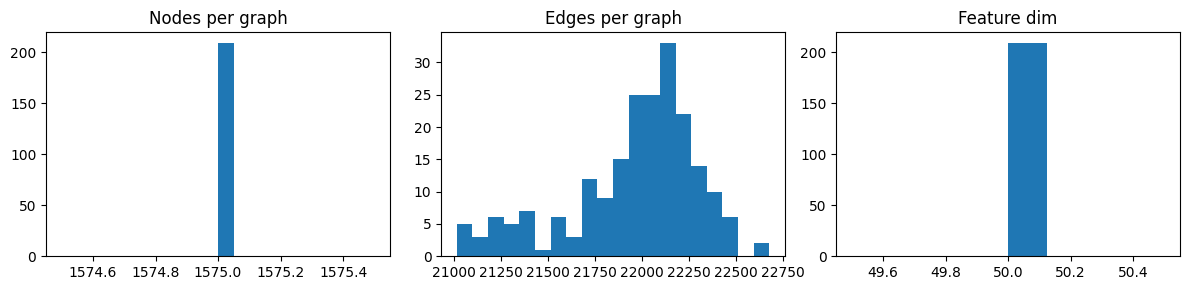

Heatmap sample: graph_0000_subj_0.npz x.shape (1575, 50) pos.shape (0, 3) edge_index.shape (2, 21188)


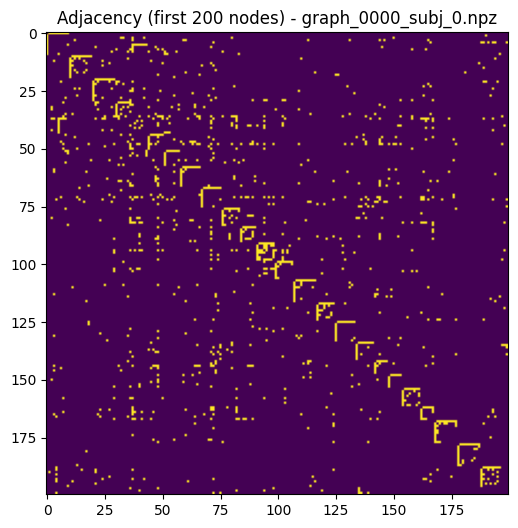

Sampled node feature matrix: (2926, 50)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved node UMAP html: /content/drive/MyDrive/oasis_project/data/graphs/visuals/node_umap.html


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved graph UMAP html: /content/drive/MyDrive/oasis_project/data/graphs/visuals/graph_umap.html


No graph with valid pos (N,3) and edges found for 3D highlight.
All visual assets (if generated) saved to: /content/drive/MyDrive/oasis_project/data/graphs/visuals
If any section didn't run, paste the printed warnings/tracebacks and I'll patch further.


In [ ]:
# Full robust visualization pipeline (single runnable snippet)
# - stats (nodes/edges/feat dim)
# - adjacency heatmap (sample)
# - node-level UMAP (sampled nodes)
# - graph-level pooled UMAP + KMeans
# - robust interactive 3D highlight (filters invalid pos/edges)
#
# Paste this cell into your notebook and run. Adjust BASE/RENPZ/OUT if needed.

import os, glob, random, numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap, plotly.graph_objects as go, plotly.express as px

# -------------------- Config --------------------
BASE = "/content/drive/MyDrive/oasis_project"
RENPZ = os.path.join(BASE, "data", "graphs", "npz_graphs_resave")   # input re-exported npz folder
OUT = os.path.join(BASE, "data", "graphs", "visuals")              # where html + images will be saved
os.makedirs(OUT, exist_ok=True)

PLOTLY_RENDERER = "colab"   # or "notebook" / "iframe" depending on environment
RANDOM_SEED = 42
SAMPLE_NODES = 3000
MAX_ADJ_HEATMAP_NODES = 200
MAX_DRAW_EDGES = 8000

random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)

# -------------------- Robust NPZ loader --------------------
def safe_load_npz(path):
    """
    Load .npz with allow_pickle and normalize fields:
      returns dict with keys 'x', 'pos', 'edge_index'
      - x: np.ndarray or None
      - pos: np.ndarray (N,3) or None
      - edge_index: np.ndarray shape (2, E) int64 (may be empty)
    """
    data = np.load(path, allow_pickle=True)
    # detect x-like keys
    x = None
    for k in ('x','X','feat','features','node_features'):
        if k in data:
            x = np.asarray(data[k])
            break
    # detect pos-like keys
    pos = None
    for k in ('pos','positions','coords','pos_xyz','node_pos'):
        if k in data:
            pos = np.asarray(data[k])
            break
    # try stacking pos if object-dtype
    if pos is not None and getattr(pos, 'dtype', None) == object:
        try:
            pos = np.vstack([np.asarray(v) for v in pos])
        except Exception:
            pos = np.asarray(pos)  # keep fallback, will be validated later

    # detect edge-like keys
    ei_raw = None
    for k in ('edge_index','edges','edge_idx','edgeIndex'):
        if k in data:
            ei_raw = data[k]
            break

    # normalize edge index into (2, E) int64 or empty
    if ei_raw is None:
        ei = np.empty((2,0), dtype=np.int64)
    else:
        ei_arr = np.asarray(ei_raw)
        try:
            if getattr(ei_arr, 'dtype', None) == object:
                li = ei_arr.tolist()
                arr = np.asarray(li)
                if arr.ndim == 2 and arr.shape[0] == 2:
                    ei = arr.astype(np.int64)
                elif arr.ndim == 2 and arr.shape[1] == 2:
                    ei = arr.T.astype(np.int64)
                else:
                    flat = np.concatenate([np.asarray(v).reshape(-1) for v in li])
                    ei = flat.reshape(2, -1).astype(np.int64)
            else:
                # numeric typed array
                if ei_arr.ndim == 1:
                    if ei_arr.size % 2 == 0:
                        ei = ei_arr.reshape(2, -1).astype(np.int64)
                    else:
                        ei = np.empty((2,0), dtype=np.int64)
                elif ei_arr.ndim == 2:
                    if ei_arr.shape[0] == 2:
                        ei = ei_arr.astype(np.int64)
                    elif ei_arr.shape[1] == 2:
                        ei = ei_arr.T.astype(np.int64)
                    else:
                        flat = ei_arr.reshape(-1)
                        if flat.size % 2 == 0:
                            ei = flat.reshape(2, -1).astype(np.int64)
                        else:
                            ei = np.empty((2,0), dtype=np.int64)
                else:
                    ei = np.empty((2,0), dtype=np.int64)
        except Exception:
            ei = np.empty((2,0), dtype=np.int64)

    return {"x": x, "pos": pos, "edge_index": ei}

# -------------------- Discover files --------------------
files = sorted(glob.glob(os.path.join(RENPZ, "*.npz")))
if len(files) == 0:
    raise RuntimeError("No npz files found in: " + RENPZ)
print(f"Found {len(files)} graphs in: {RENPZ}")

# -------------------- Global stats --------------------
node_counts, edge_counts, feat_dims = [], [], []
for p in files:
    try:
        d = safe_load_npz(p)
        x = d['x']
        ei = d['edge_index']
        node_counts.append(int(x.shape[0]) if (x is not None and hasattr(x, 'shape')) else 0)
        if x is None:
            feat_dims.append(0)
        else:
            feat_dims.append(int(x.shape[1]) if (x.ndim>1) else 1)
        if isinstance(ei, np.ndarray):
            edge_counts.append(int(ei.shape[1]))
        else:
            edge_counts.append(0)
    except Exception as e:
        print("Warning loading", os.path.basename(p), e)
        node_counts.append(0); edge_counts.append(0); feat_dims.append(0)

print("Nodes per graph: min/median/mean/max =", np.min(node_counts), np.median(node_counts), np.mean(node_counts), np.max(node_counts))
print("Edges per graph: min/median/mean/max =", np.min(edge_counts), np.median(edge_counts), np.mean(edge_counts), np.max(edge_counts))
print("Feature dim (sample first):", feat_dims[0])

# histograms
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); plt.hist(node_counts, bins=20); plt.title("Nodes per graph")
plt.subplot(1,3,2); plt.hist(edge_counts, bins=20); plt.title("Edges per graph")
plt.subplot(1,3,3); plt.hist(feat_dims, bins=8); plt.title("Feature dim")
plt.tight_layout(); plt.show()

# -------------------- Adjacency heatmap (sample) --------------------
sample_heatmap = None
for f in files:
    dtmp = safe_load_npz(f)
    ei = dtmp['edge_index']
    if isinstance(ei, np.ndarray) and ei.size > 0 and ei.ndim == 2 and ei.shape[0] == 2:
        sample_heatmap = f
        break

if sample_heatmap is None:
    print("No graph with valid edges found for adjacency heatmap.")
else:
    d = safe_load_npz(sample_heatmap)
    print("Heatmap sample:", os.path.basename(sample_heatmap), "x.shape", None if d['x'] is None else d['x'].shape, "pos.shape", None if d['pos'] is None else getattr(d['pos'],'shape',None), "edge_index.shape", d['edge_index'].shape)
    def adj_heatmap(d, maxn=MAX_ADJ_HEATMAP_NODES):
        ei = d['edge_index']
        if ei is None or ei.size == 0:
            print("No edges for heatmap.")
            return
        r = np.asarray(ei[0]).astype(int); c = np.asarray(ei[1]).astype(int)
        # choose keep based on available max index and the requested maxn
        max_index = max(int(r.max())+1 if r.size>0 else 0, int(c.max())+1 if c.size>0 else 0)
        keep = min(maxn, max(max_index, 1))
        mask = (r >= 0) & (r < keep) & (c >= 0) & (c < keep)
        A = np.zeros((keep, keep), dtype=int)
        for rr, cc in zip(r[mask], c[mask]):
            A[int(rr), int(cc)] = 1
        plt.figure(figsize=(6,6)); plt.imshow(A, cmap='viridis'); plt.title(f'Adjacency (first {keep} nodes) - {os.path.basename(sample_heatmap)}'); plt.show()
    adj_heatmap(d, maxn=MAX_ADJ_HEATMAP_NODES)

# -------------------- Node-level UMAP (sample across graphs) --------------------
def sample_node_features(files, max_nodes=SAMPLE_NODES, min_per_graph=5):
    Xs = []; color_mean = []
    per_graph = max(min_per_graph, max_nodes // max(1, len(files)))
    total = 0
    for p in files:
        d = safe_load_npz(p)
        x = d['x']
        if x is None or getattr(x, 'size', 0) == 0:
            continue
        n = int(x.shape[0])
        k = min(n, per_graph)
        idxs = np.random.choice(n, k, replace=(k>n))
        Xs.append(x[idxs])
        if x.ndim > 1:
            color_mean.extend(x[idxs].mean(axis=1).tolist())
        else:
            color_mean.extend(x[idxs].tolist())
        total += k
        if total >= max_nodes:
            break
    if len(Xs) == 0:
        return np.empty((0,0)), np.empty((0,))
    X = np.vstack(Xs).astype(np.float32)
    return X, np.array(color_mean)

X_nodes, col_mean = sample_node_features(files)
print("Sampled node feature matrix:", X_nodes.shape)
if X_nodes.size and X_nodes.shape[0] > 15 and X_nodes.shape[1] > 0:
    try:
        Xs = StandardScaler().fit_transform(X_nodes)
    except Exception:
        Xs = X_nodes
    reducer = umap.UMAP(n_components=2, random_state=RANDOM_SEED)
    Z = reducer.fit_transform(Xs)
    # cluster for coloring
    pca_comps = min(16, Xs.shape[1])
    if pca_comps > 0:
        pca = PCA(n_components=pca_comps).fit_transform(Xs)
        km_c = min(6, max(2, pca.shape[0]//50))  # heuristic clusters
        if km_c > 1:
            km = KMeans(n_clusters=km_c, random_state=RANDOM_SEED, n_init=10).fit(pca)
            labels = km.labels_.astype(str)
            fig_node = px.scatter(x=Z[:,0], y=Z[:,1], color=labels, hover_data=[col_mean], title="Node UMAP (clustered)", width=900, height=600)
            node_html = os.path.join(OUT, "node_umap.html"); fig_node.write_html(node_html); print("Saved node UMAP html:", node_html)
            fig_node.show(renderer=PLOTLY_RENDERER)
        else:
            print("Not enough node samples for KMeans.")
    else:
        print("Feature dimensionality too small for PCA/KMeans.")
else:
    print("Not enough sampled nodes for node-level UMAP (need >15 samples).")

# -------------------- Graph-level pooled UMAP + KMeans --------------------
G_feats = []; G_names = []
for p in files:
    d = safe_load_npz(p)
    x = d['x']
    if x is None or getattr(x, 'size', 0) == 0:
        continue
    arr = x if x.ndim > 1 else x[:, np.newaxis]
    if arr.shape[0] > 1:
        feat = np.concatenate([arr.mean(axis=0), arr.std(axis=0), arr.max(axis=0)])
    else:
        feat = np.concatenate([arr.mean(axis=0), np.zeros_like(arr.mean(axis=0)), arr.max(axis=0)])
    G_feats.append(feat); G_names.append(os.path.basename(p))

if len(G_feats) >= 16 and len(G_feats[0]) > 1:
    maxlen = max(v.shape[0] for v in G_feats)
    G_mat = np.vstack([np.pad(v, (0, maxlen - v.shape[0]), 'constant') for v in G_feats]).astype(np.float32)
    G_emb = umap.UMAP(n_components=2, random_state=RANDOM_SEED).fit_transform(G_mat)
    k = min(6, max(2, int(len(G_mat)**0.5)))
    if k > 1:
        labels = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10).fit_predict(G_emb)
        fig_g = px.scatter(x=G_emb[:,0], y=G_emb[:,1], color=labels.astype(str), hover_name=G_names, title="Graph-level UMAP (pooled) + KMeans", width=900, height=600)
        graph_html = os.path.join(OUT, "graph_umap.html"); fig_g.write_html(graph_html); print("Saved graph UMAP html:", graph_html)
        fig_g.show(renderer=PLOTLY_RENDERER)
    else:
        print("Not enough graphs for KMeans clustering.")
else:
    print("Not enough graph-level features for graph UMAP (need >=16 graphs with features).")

# -------------------- Robust interactive 3D highlight --------------------
# Find first graph with valid pos (N,3) and edges
sample3d = None
for p in files:
    dtmp = safe_load_npz(p)
    pos = dtmp['pos']
    ei = dtmp['edge_index']
    # quick validation
    if pos is None or getattr(pos, 'size', 0) == 0:
        continue
    pos_arr = np.asarray(pos)
    if pos_arr.ndim != 2 or pos_arr.shape[1] != 3:
        continue
    if not (isinstance(ei, np.ndarray) and ei.size > 0 and ei.ndim == 2 and ei.shape[0] == 2):
        continue
    sample3d = p; d3 = dtmp; break

if sample3d is None:
    print("No graph with valid pos (N,3) and edges found for 3D highlight.")
else:
    print("3D sample:", os.path.basename(sample3d))
    # robust 3D plotting with filtering of invalid edges / indices
    try:
        pos = np.asarray(d3['pos'])
        if pos.dtype == object:
            try:
                pos = np.vstack([np.asarray(v) for v in pos])
            except Exception:
                pos = np.asarray(pos)
        if pos.size == 0 or pos.ndim != 2 or pos.shape[1] != 3:
            raise RuntimeError(f"Invalid pos array shape: {getattr(pos,'shape', None)}")

        ei = np.asarray(d3['edge_index'])
        # normalize ei shape
        if ei.ndim == 1 and ei.size % 2 == 0:
            ei = ei.reshape(2, -1)
        elif ei.ndim == 2 and ei.shape[1] == 2 and ei.shape[0] != 2:
            ei = ei.T
        elif not (ei.ndim == 2 and ei.shape[0] == 2):
            ei = np.empty((2,0), dtype=np.int64)

        r = np.asarray(ei[0]).astype(int) if ei.size>0 else np.array([], dtype=int)
        c = np.asarray(ei[1]).astype(int) if ei.size>0 else np.array([], dtype=int)
        N = pos.shape[0]
        print("pos.shape:", pos.shape, "raw edge count:", r.size)

        # keep only edges where both endpoints are valid indices
        if r.size > 0:
            valid_mask = (r >= 0) & (r < N) & (c >= 0) & (c < N)
            valid_r = r[valid_mask]; valid_c = c[valid_mask]
        else:
            valid_r = valid_c = np.array([], dtype=int)

        # compute degrees from valid edges
        if valid_r.size > 0:
            deg = np.bincount(np.concatenate([valid_r, valid_c]), minlength=N)
        else:
            deg = np.zeros(N, dtype=int)

        # top-degree nodes (cap to available N)
        topk_count = min(6, N)
        topk = deg.argsort()[-topk_count:][::-1]
        print("Top-degree nodes (idx:degree):", [(int(i), int(deg[i])) for i in topk])

        # build figure
        fig3 = go.Figure()
        fig3.add_trace(go.Scatter3d(x=pos[:,0], y=pos[:,1], z=pos[:,2], mode='markers',
                                    marker=dict(size=2, color='lightgrey'), name='nodes', opacity=0.6))

        # sample edges to draw
        if valid_r.size > 0:
            idxs = np.arange(valid_r.size)
            if idxs.size > MAX_DRAW_EDGES:
                chosen = np.random.choice(idxs, MAX_DRAW_EDGES, replace=False)
            else:
                chosen = idxs
            xs=[]; ys=[]; zs=[]
            for i in chosen:
                a = int(valid_r[i]); b = int(valid_c[i])
                if not (0 <= a < N and 0 <= b < N):
                    continue
                xs += [float(pos[a,0]), float(pos[b,0]), None]
                ys += [float(pos[a,1]), float(pos[b,1]), None]
                zs += [float(pos[a,2]), float(pos[b,2]), None]
            if len(xs) > 0:
                fig3.add_trace(go.Scatter3d(x=xs, y=ys, z=zs, mode='lines',
                                            line=dict(width=1, color='rgba(120,120,120,0.15)'), name='edges'))
            else:
                print("No drawable edges after filtering.")
        else:
            print("No valid edges to draw; nodes only.")

        colors = px.colors.qualitative.Dark24
        for j, nid in enumerate(topk):
            nid = int(nid)
            if nid < 0 or nid >= N:
                continue
            if valid_r.size > 0:
                neigh_mask = (valid_r == nid) | (valid_c == nid)
                neighs = np.unique(np.concatenate([valid_r[neigh_mask], valid_c[neigh_mask]])) if np.any(neigh_mask) else np.array([], dtype=int)
            else:
                neighs = np.array([], dtype=int)
            neighs = neighs[(neighs >= 0) & (neighs < N)]
            if neighs.size > 0:
                pts = pos[neighs]
                fig3.add_trace(go.Scatter3d(x=pts[:,0], y=pts[:,1], z=pts[:,2], mode='markers',
                                            marker=dict(size=4, color=colors[j % len(colors)]), name=f'neigh_top{j}'))
            fig3.add_trace(go.Scatter3d(x=[float(pos[nid,0])], y=[float(pos[nid,1])], z=[float(pos[nid,2])],
                                        mode='markers', marker=dict(size=6, color=colors[j % len(colors)], symbol='diamond'),
                                        name=f'top{j}_node_{nid}'))

        fig3.update_layout(scene=dict(aspectmode='data'), title=f"Top-degree nodes + neighbors ({os.path.basename(sample3d)})")
        html3 = os.path.join(OUT, "visual_3d_sample_filtered.html"); fig3.write_html(html3); print("Saved 3D HTML to:", html3)
        fig3.show(renderer=PLOTLY_RENDERER)

    except Exception as e:
        print("3D highlight build failed:", type(e), e)

# -------------------- Done --------------------
print("All visual assets (if generated) saved to:", OUT)
print("If any section didn't run, paste the printed warnings/tracebacks and I'll patch further.")
